# Analyzing Music Store Data <br>


* [Enabling SQL and importing necessary libraries](#load) <br>


* [Introduction to the data](#intro) <br>


* [Which music genre is the most popular?](#question1) <br>


* [Which employee is worth their money?](#question2) <br>


* [Which country spends the most?](#question3) <br>



<a class="anchor" id="totop"></a>



## Enabling SQL and importing necessary libraries <a class="anchor" id="load"></a>  <br>

Before we take a closer look at the provided data we are enabling SQL in our Jupyter Notebook, connect to the database and import some libraries.

In [64]:
%%capture
%load_ext sql
%sql sqlite:///chinook.db

'Connected: None@chinook.db'

In [86]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Import python libraries
import sqlite3 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.core.display import HTML 
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

## Introduction to the data <a class="anchor" id="intro"></a>  <br>

The music store "Chinook" has provided us with its database in order to help them analyze their business and help with some decisions the store faces.

Here we see the schema of their database. 


In [66]:
Image(url= "https://s3.amazonaws.com/dq-content/191/chinook-schema.svg", width=700, height=200)

To get a better idea of what those tables consist of we use a few simple queries.

In [67]:
%%sql

SELECT
    name,
    type
FROM sqlite_master
WHERE type IN ("table", "view");

Done.


name,type
album,table
artist,table
customer,table
employee,table
genre,table
invoice,table
invoice_line,table
media_type,table
playlist,table
playlist_track,table


In [68]:
%%sql

SELECT *
FROM playlist_track
LIMIT 5;

Done.


playlist_id,track_id
1,3402
1,3389
1,3390
1,3391
1,3392


In [69]:
%%sql

SELECT * 
FROM invoice
LIMIT 5;

Done.


invoice_id,customer_id,invoice_date,billing_address,billing_city,billing_state,billing_country,billing_postal_code,total
1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84
2,30,2017-01-03 00:00:00,230 Elgin Street,Ottawa,ON,Canada,K2P 1L7,9.9
3,40,2017-01-05 00:00:00,"8, Rue Hanovre",Paris,None,France,75002,1.98
4,18,2017-01-06 00:00:00,627 Broadway,New York,NY,USA,10012-2612,7.92
5,27,2017-01-07 00:00:00,1033 N Park Ave,Tucson,AZ,USA,85719,16.83


[To Top](#totop) 


## Which music genre is the most popular? <a class="anchor" id="question1"></a>  <br>


Chinook is working with a record label which has four brand new albums coming out. Chinook is able to add three of those to their selection and now wants to know which they should choose. Since the artists and genres are all different we are gonna find out which genres sell best in our store. The record label is based in the USA so we only include customers with a billing address there.

The artists and genres to choose from are:

|Artist Name|Genre|
|-|-|
|Regal|Hip-Hop|
|Red Tone|Punk|
|Meteor and the Girls|Pop|
|Slim Jum Bites|Blues|

We use the following query to sort all genres by the number of tracks sold.

In [70]:
%%sql

WITH sold_tracks_usa AS 
    (
    SELECT *
    FROM invoice_line il
    INNER JOIN invoice i ON il.invoice_id = i.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    WHERE c.country = "USA"
    )

SELECT 
    g.name genre,
    COUNT(stu.invoice_line_id) tracks_sold,
    ROUND((CAST(COUNT(stu.invoice_line_id) AS FLOAT) 
           / (
               SELECT COUNT(*)
               FROM sold_tracks_usa) * 100), 2) percentage
    
FROM sold_tracks_usa stu
INNER JOIN track t ON stu.track_id = t.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC;


Done.


genre,tracks_sold,percentage
Rock,561,53.38
Alternative & Punk,130,12.37
Metal,124,11.8
R&B/Soul,53,5.04
Blues,36,3.43
Alternative,35,3.33
Latin,22,2.09
Pop,22,2.09
Hip Hop/Rap,20,1.9
Jazz,14,1.33


In [90]:
# create variable to be passed into pd.read_sql

query_genres ="""WITH sold_tracks_usa AS 
    (
    SELECT *
    FROM invoice_line il
    INNER JOIN invoice i ON il.invoice_id = i.invoice_id
    INNER JOIN customer c ON c.customer_id = i.customer_id
    WHERE c.country = "USA"
    )

SELECT 
    g.name genre,
    COUNT(stu.invoice_line_id) tracks_sold,
    ROUND((CAST(COUNT(stu.invoice_line_id) AS FLOAT) 
           / (
               SELECT COUNT(*)
               FROM sold_tracks_usa) * 100), 2) percentage
    
FROM sold_tracks_usa stu
INNER JOIN track t ON stu.track_id = t.track_id
INNER JOIN genre g ON g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC;

"""

# Connect to database
conn = sqlite3.connect('chinook.db')

# Read into dataframe
genre_stats = pd.read_sql(query_genres, conn)

genre_stats

,genre,tracks_sold,percentage
0,Rock,561,53.38
1,Alternative & Punk,130,12.37
2,Metal,124,11.80
3,R&B/Soul,53,5.04
4,Blues,36,3.43
5,Alternative,35,3.33
6,Latin,22,2.09
7,Pop,22,2.09
8,Hip Hop/Rap,20,1.90
9,Jazz,14,1.33


 <br>
We can see that there are relatively few genres making up the majority of our track sales in the US, so we are gonna group the ones below 1.9% of sales volume in the "Others" category.  <br>

In [72]:
genre_stats["genre"] = genre_stats["genre"].mask(genre_stats["percentage"] <1.9, "Others")
genre_stats.drop("tracks_sold", axis = 1, inplace=True)
genre_stats.reset_index(level=0, inplace=True)
genre_stats

,index,genre,percentage
0,0,Rock,53.38
1,1,Alternative & Punk,12.37
2,2,Metal,11.80
3,3,R&B/Soul,5.04
4,4,Blues,3.43
5,5,Alternative,3.33
6,6,Latin,2.09
7,7,Pop,2.09
8,8,Hip Hop/Rap,1.90
9,9,Others,1.33


In [73]:
genre_stats = genre_stats.groupby("genre").sum()
genre_stats = genre_stats.sort_values("percentage", ascending=False)

In [74]:
genre_stats["sort"] = 0
genre_stats.at['Others', 'sort'] = 1

In [75]:
genre_stats = genre_stats.sort_values("sort").drop("sort", axis=1).drop("index", axis=1)

In [76]:
genre_stats

,percentage
genre,
Rock,53.38
Alternative & Punk,12.37
Metal,11.80
R&B/Soul,5.04
Blues,3.43
Alternative,3.33
Latin,2.09
Pop,2.09
Hip Hop/Rap,1.90


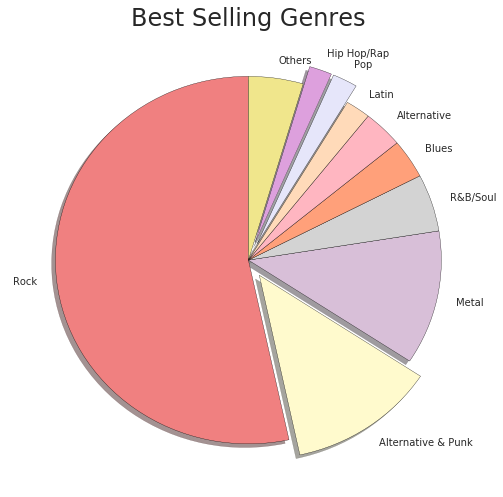

In [77]:
plt.figure(figsize=(7,7))
explode = (0, 0.1, 0, 0, 0, 0, 0, 0.1, 0.1, 0)
colors = ("lightcoral", "lemonchiffon", "thistle", 
          "lightgrey", "lightsalmon", "lightpink", "peachpuff", 
          "lavender", "plum", "khaki") 
labels = genre_stats.index

plt.pie(genre_stats["percentage"], labels=labels,
        colors = colors, 
        pctdistance = 0.8,
        explode=explode, 
        startangle=90, 
        shadow=True,   
        textprops={'fontsize': 9})
plt.title("Best Selling Genres", fontsize=24)

plt.tight_layout()
plt.show();


Based on our analysis we would recommend to add the following albums to Chinook's portfolio:

|Artist Name|Genre|Share of Sales|
|-|-|-|
|Red Tone|Punk|12.4%|
|Slim Jum Bites|Blues|3.4%|
|Meteor and the Girls|Pop|2.1%|

<u> Further analysis: </u>

- We would highly recommend Chinook to seek out more rock artists since that genre makes up more than half of the tracks sold in the US.  <br>


- Additionally we wonder if the categorization into "Alternative" and "Alternative & Punk" is the best way to group artists since we imagine both of them cover basically the same market. We would recommend to either pool both into a single category or to separate them into an "Alternative" and a "Punk" section. 

[To Top](#totop) 


## Which employee is worth their money? <a class="anchor" id="question2"></a>

Chinook is interested in the performance of their sale support agents. Based on the information we have we are first gonna find out which agents perform well using the complete amount of customer purchases to their name. To make this ranking comparable we also need to know the amount of time they have been working for the store, since the total amount of money earned is directly related to the time someone has been employed.

We are using the SQLite function JULIANDAY() to calculate the exact number of days from each employee's hiring date to the current day. This allows us to calculate the average sales rate per day, which is a better performance indicator than the total amount spent.

In [89]:
%%sql

WITH dullars AS (
    SELECT *
    FROM invoice i
    INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    e.first_name || " " || e.last_name name,
    ROUND(SUM(total), 2) dollar_spent,
    CAST(julianday(datetime("now")) AS INT) - 
        CAST(julianday(datetime(e.hire_date)) AS INT)
        AS days_employed,
    ROUND((CAST(julianday(datetime("now")) AS INT) - 
        CAST(julianday(datetime(e.hire_date)) AS INT)) 
        / ROUND(SUM(total), 2), 3) AS average_dollars_per_day       
    
FROM dullars d
INNER JOIN employee e ON e.employee_id = d.support_rep_id
GROUP BY 1
ORDER BY 4 DESC;

Done.


name,dollar_spent,days_employed,average_dollars_per_day
Steve Johnson,1393.92,1605,1.151
Margaret Park,1584.0,1772,1.119
Jane Peacock,1731.51,1804,1.042


Here we can see the effect of considering the time spent as an employee. Although Jane Peacock has earned the store the most money in absolute numbers, she is bested by two other employees judging on the average sale amount per day. 

[To Top](#totop) 

## Which country spends the most? <a class="anchor" id="question3"></a>  <br>


Let's now collate data on purchases for customers from different countries, including the total number of customers, the total value of sales, average value of sales per customer as well as the average order value. Because some countries only have a couple of customers we collect those countries in the category "Other". The results will be presented in grouped bar charts.

In [79]:
%%sql

SELECT *
FROM invoice
LIMIT 10;

Done.


invoice_id,customer_id,invoice_date,billing_address,billing_city,billing_state,billing_country,billing_postal_code,total
1,18,2017-01-03 00:00:00,627 Broadway,New York,NY,USA,10012-2612,15.84
2,30,2017-01-03 00:00:00,230 Elgin Street,Ottawa,ON,Canada,K2P 1L7,9.9
3,40,2017-01-05 00:00:00,"8, Rue Hanovre",Paris,None,France,75002,1.98
4,18,2017-01-06 00:00:00,627 Broadway,New York,NY,USA,10012-2612,7.92
5,27,2017-01-07 00:00:00,1033 N Park Ave,Tucson,AZ,USA,85719,16.83
6,31,2017-01-10 00:00:00,194A Chain Lake Drive,Halifax,NS,Canada,B3S 1C5,1.98
7,49,2017-01-12 00:00:00,Ordynacka 10,Warsaw,None,Poland,00-358,10.89
8,59,2017-01-13 00:00:00,"3,Raj Bhavan Road",Bangalore,None,India,560001,9.9
9,18,2017-01-18 00:00:00,627 Broadway,New York,NY,USA,10012-2612,8.91
10,31,2017-01-18 00:00:00,194A Chain Lake Drive,Halifax,NS,Canada,B3S 1C5,1.98


In [80]:
%%sql

WITH country_or_other AS
    (
     SELECT
           CASE
               WHEN (
                 SELECT count(*)
                 FROM customer
                 WHERE country = c.country
                 ) = 1 THEN "Other"
               ELSE c.country
           END AS country,
           c.customer_id,
           il.*
     FROM customer c
     INNER JOIN invoice i ON i.customer_id = c.customer_id
     INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
    )
    
SELECT 
    country,
    customers,
    total_sales,
    customer_lifetime_value,
    average_order
FROM
    (

    SELECT  
        country,
        count(DISTINCT customer_id) customers,
        ROUND(SUM(unit_price), 2) total_sales,
        ROUND(SUM(unit_price) / count(DISTINCT customer_id), 2) customer_lifetime_value,
        ROUND(SUM(unit_price) / count(DISTINCT invoice_id), 2) average_order
    FROM (
        SELECT
            *,
            CASE
                WHEN country = "Other" THEN 1
                ELSE 0
            END AS sort
        FROM country_or_other)

    GROUP BY 1
    ORDER BY sort ASC, customers DESC
    );


Done.


country,customers,total_sales,customer_lifetime_value,average_order
USA,13,1040.49,80.04,7.94
Canada,8,535.59,66.95,7.05
Brazil,5,427.68,85.54,7.01
France,5,389.07,77.81,7.78
Germany,4,334.62,83.66,8.16
United Kingdom,3,245.52,81.84,8.77
Czech Republic,2,273.24,136.62,9.11
India,2,183.15,91.58,8.72
Portugal,2,185.13,92.57,6.38
Other,15,1094.94,73.0,7.45


In [81]:
# Create variable to be passed into pd.read_sql

query_country ="""WITH country_or_other AS
    (
     SELECT
           CASE
               WHEN (
                 SELECT count(*)
                 FROM customer
                 WHERE country = c.country
                 ) = 1 THEN "Other"
               ELSE c.country
           END AS country,
           c.customer_id,
           il.*
     FROM customer c
     INNER JOIN invoice i ON i.customer_id = c.customer_id
     INNER JOIN invoice_line il ON il.invoice_id = i.invoice_id
    )
    
SELECT 
    country,
    customers,
    total_sales,
    customer_lifetime_value,
    average_order
FROM
    (

    SELECT  
        country,
        count(DISTINCT customer_id) customers,
        ROUND(SUM(unit_price), 2) total_sales,
        ROUND(SUM(unit_price) / count(DISTINCT customer_id), 2) customer_lifetime_value,
        ROUND(SUM(unit_price) / count(DISTINCT invoice_id), 2) average_order
    FROM (
        SELECT
            *,
            CASE
                WHEN country = "Other" THEN 1
                ELSE 0
            END AS sort
        FROM country_or_other)

    GROUP BY 1
    ORDER BY sort ASC, customers DESC
    );

"""

# Connect to database
conn = sqlite3.connect('chinook.db')

# Read into dataframe
country_stats = pd.read_sql(query_country, conn)

country_stats

,country,customers,total_sales,customer_lifetime_value,average_order
0,USA,13,1040.49,80.04,7.94
1,Canada,8,535.59,66.95,7.05
2,Brazil,5,427.68,85.54,7.01
3,France,5,389.07,77.81,7.78
4,Germany,4,334.62,83.66,8.16
5,United Kingdom,3,245.52,81.84,8.77
6,Czech Republic,2,273.24,136.62,9.11
7,India,2,183.15,91.58,8.72
8,Portugal,2,185.13,92.57,6.38
9,Other,15,1094.94,73.00,7.45


In [82]:
country_stats = country_stats.set_index("country", drop=True)
country_list = country_stats.index.tolist()


In [83]:
country_stats.info()
country_list

<class 'pandas.core.frame.DataFrame'>
Index: 10 entries, USA to Other
Data columns (total 4 columns):
customers                  10 non-null int64
total_sales                10 non-null float64
customer_lifetime_value    10 non-null float64
average_order              10 non-null float64
dtypes: float64(3), int64(1)
memory usage: 400.0+ bytes


['USA',
 'Canada',
 'Brazil',
 'France',
 'Germany',
 'United Kingdom',
 'Czech Republic',
 'India',
 'Portugal',
 'Other']

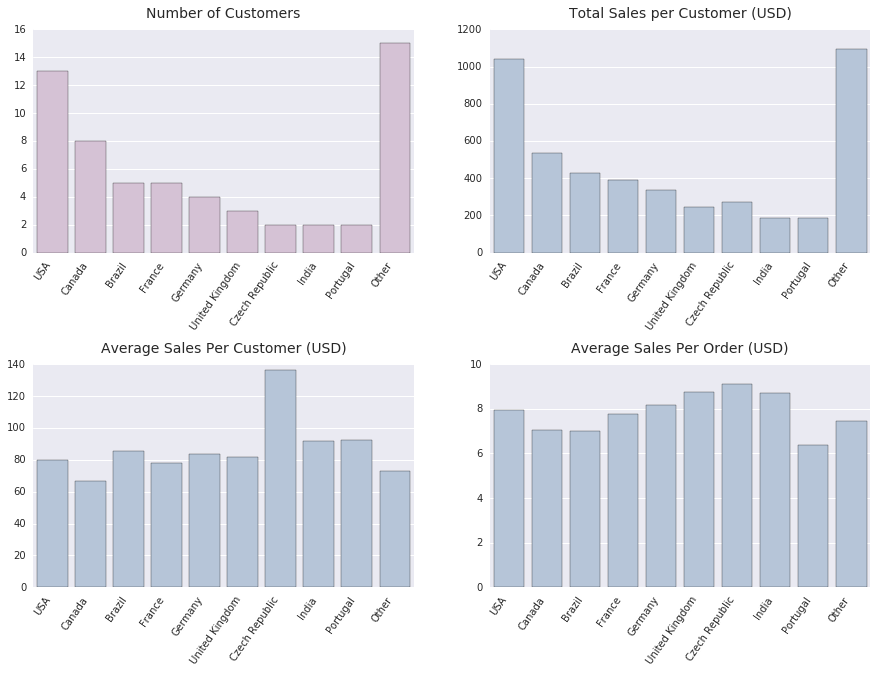

In [84]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15,10))
fig.subplots_adjust(hspace=0.5)

ax1 = plt.subplot(2,2,1)
ax1 = sns.barplot(country_list, "customers", data=country_stats, color="thistle")
plt.xticks(rotation = 55, ha="right")
ax1.set_title('Number of Customers', fontsize=14, y=1.03)
ax1.set_ylabel('')
sns.despine(left=True)

ax2 = plt.subplot(2,2,2)
ax2 = sns.barplot(country_list, "total_sales", data=country_stats, color="lightsteelblue")
plt.xticks(rotation = 55, ha="right")
ax2.set_title('Total Sales per Customer (USD)', fontsize=14, y=1.03)
ax2.set_ylabel('')
sns.despine(left=True)

ax3 = plt.subplot(2,2,3)
ax3 = sns.barplot(country_list, "customer_lifetime_value", data=country_stats, color="lightsteelblue")
plt.xticks(rotation = 55, ha="right")
ax3.set_title('Average Sales Per Customer (USD)', fontsize=14, y=1.03)
ax3.set_ylabel('')
sns.despine(left=True)

ax4 = plt.subplot(2,2,4)
ax4 = sns.barplot(country_list, "average_order", data=country_stats, color="lightsteelblue")
plt.xticks(rotation = 55, ha="right")
ax4.set_title("Average Sales Per Order (USD)", fontsize=14, y=1.03)
ax4.set_ylabel('')
sns.despine(left=True);



We can see the sales by country are clearly dominated by the USA, in terms of both the total sales and the number of customers (excluding the "Other" group). Besides, we can notice a strong positive correlation between the number of customers and the total sales. Interesting from a statistics points of view is that the Czech Republic, having only 2 customers, shows the highest average value of sales per customer and, consequently, the highest average order value.

[To Top](#totop) 